In [ ]:
# Установка зависимостей
!pip install "networkx==2.3" "decorator==4.3.0" "numpy<1.24" mordred[full] rdkit-pypi chembl-webresource-client

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.4/69.4 kB 4.5 MB/s eta 0:00:00


### Расчет корреляций и понижение размерности

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import requests
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import rdFingerprintGenerator
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# 1. Загрузка данных ChEMBL по Ki для эстрогенового альфа-рецептора
url = ("https://www.ebi.ac.uk/chembl/api/data/activity.json?"
       "target_chembl_id=CHEMBL206&standard_type=Ki&standard_units=nM&limit=10000")
resp = requests.get(url)
data = resp.json()['activities']
print(f'Всего записей из ChEMBL: {len(data)}')
df = pd.DataFrame(data)

Всего записей из ChEMBL: 713


In [ ]:
mol = Chem.MolFromSmiles(df['canonical_smiles'][0])
rdkgen = rdFingerprintGenerator.GetRDKitFPGenerator()
np_bits = rdkgen.GetFingerprintAsNumPy(mol)
np_bits, np.sum(np_bits)

(array([0, 1, 0, ..., 0, 0, 1], dtype=uint8), 1041)

In [ ]:
df.columns

Index(['action_type', 'activity_comment', 'activity_id', 'activity_properties',
       'assay_chembl_id', 'assay_description', 'assay_type',
       'assay_variant_accession', 'assay_variant_mutation', 'bao_endpoint',
       'bao_format', 'bao_label', 'canonical_smiles', 'data_validity_comment',
       'data_validity_description', 'document_chembl_id', 'document_journal',
       'document_year', 'ligand_efficiency', 'molecule_chembl_id',
       'molecule_pref_name', 'parent_molecule_chembl_id', 'pchembl_value',
       'potential_duplicate', 'qudt_units', 'record_id', 'relation', 'src_id',
       'standard_flag', 'standard_relation', 'standard_text_value',
       'standard_type', 'standard_units', 'standard_upper_value',
       'standard_value', 'target_chembl_id', 'target_organism',
       'target_pref_name', 'target_tax_id', 'text_value', 'toid', 'type',
       'units', 'uo_units', 'upper_value', 'value'],
      dtype='object')

Получшенный вами датасет с практики, как и датасет с минитаска 2, будет использоваться для выполнения минитаска 3, после завтрашней лекции про машинное обучение.

Всего записей из ChEMBL: 1000
После удаления строк без MOL/IC50: 942
После расчета дескрипторов: 942 строк
Колонки после RDKit-дескрипторов (210):
['MOL', 'pValue', 'MaxEStateIndex', 'MinEStateIndex', 'MaxAbsEStateIndex', 'MinAbsEStateIndex', 'qed', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'NumRadicalElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_

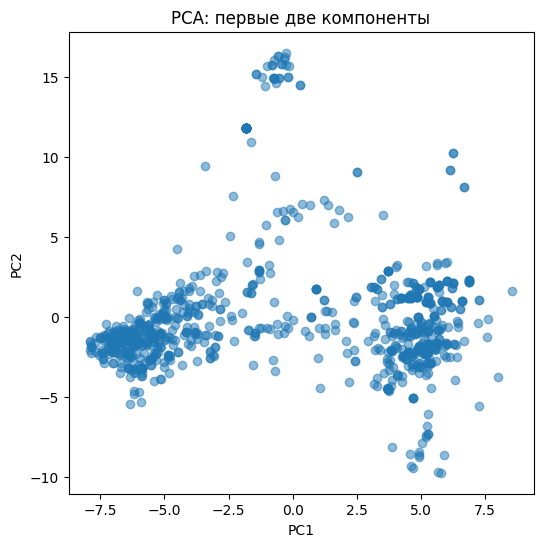

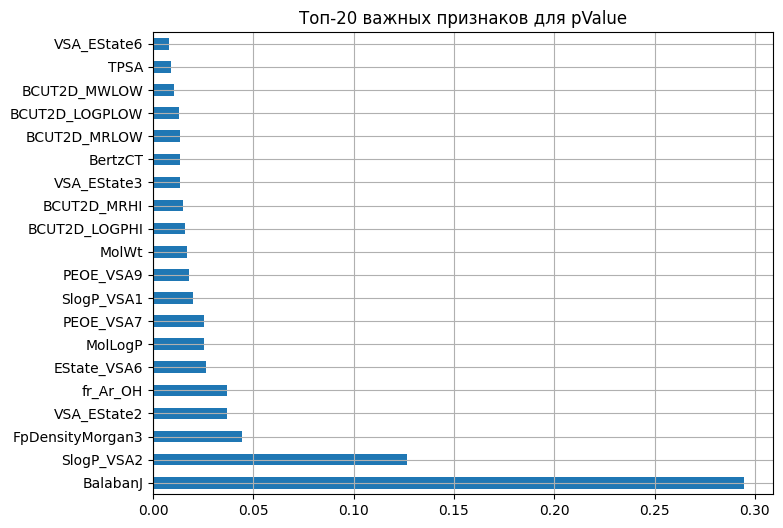

/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


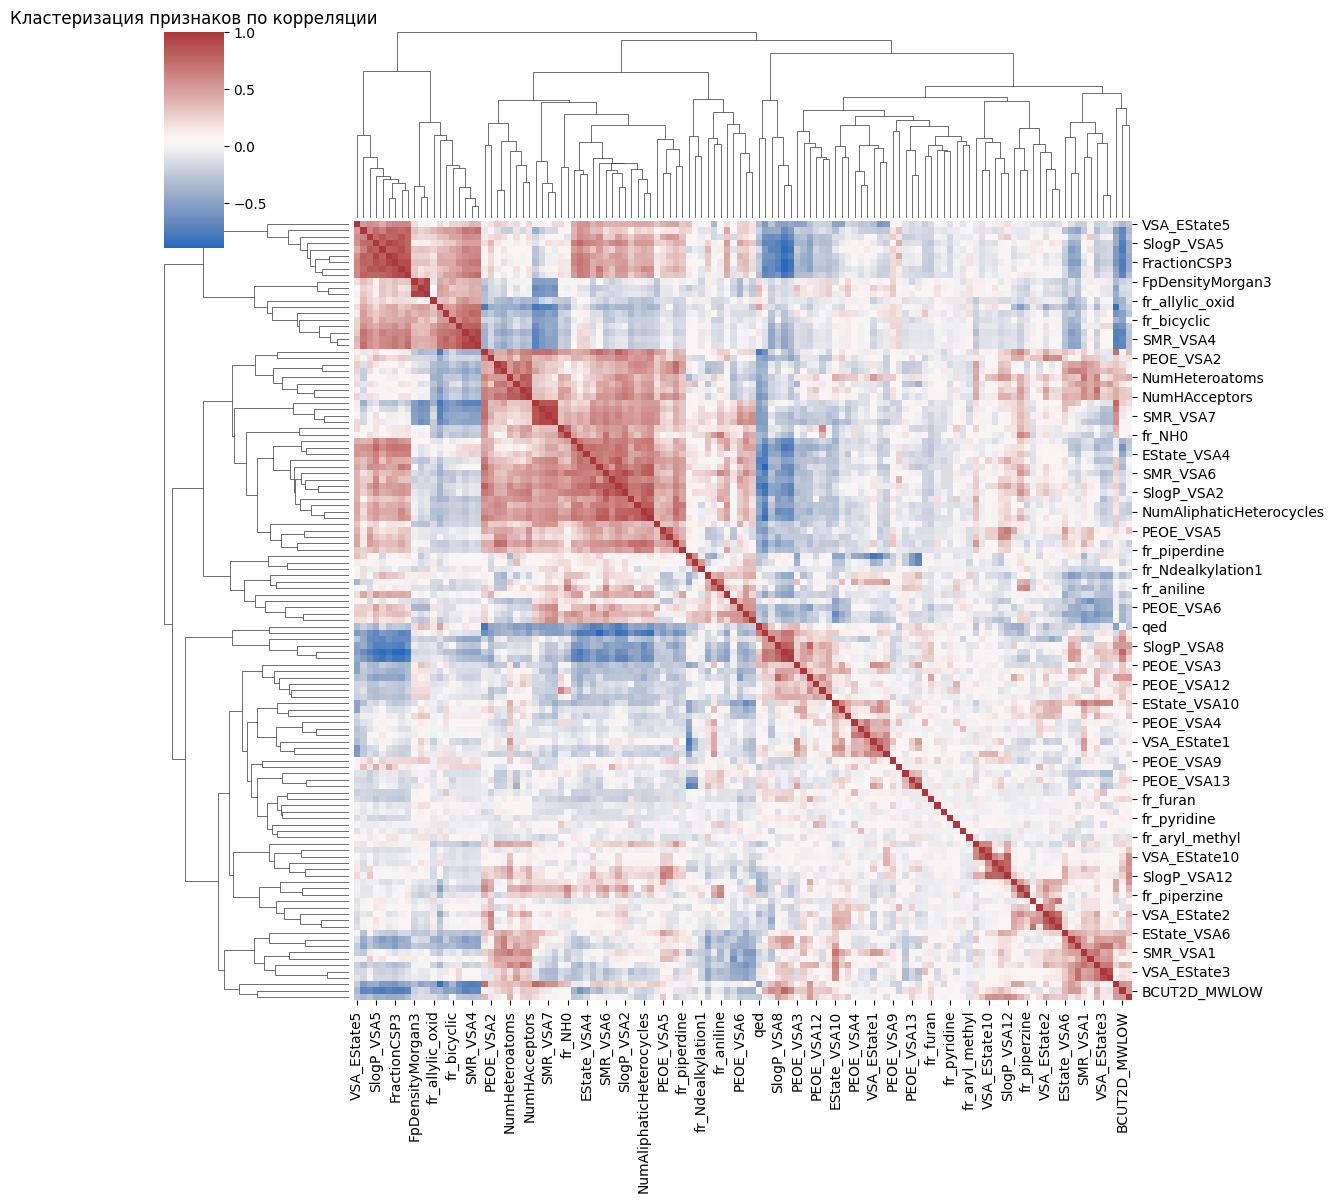

In [247]:
# 1. Загрузка данных ChEMBL по IC50 для эстрогенового альфа-рецептора
url = ("https://www.ebi.ac.uk/chembl/api/data/activity.json?"
       "target_chembl_id=CHEMBL206&standard_type=IC50&standard_units=nM&limit=10000")
resp = requests.get(url)
data = resp.json()['activities']
print(f'Всего записей из ChEMBL: {len(data)}')
df = pd.DataFrame(data)

# 2. Оставляем только RowMol (если есть) или SMILES и pValue
mol_col = 'RowMol' if 'RowMol' in df.columns else 'canonical_smiles'
df = df[df[mol_col].notna() & df['standard_value'].notna()]
df['Ki_nM'] = pd.to_numeric(df['standard_value'], errors='coerce')
df = df[df['Ki_nM'] > 0]
df['pValue'] = 9 - np.log10(df['Ki_nM'])
df = df[[mol_col, 'pValue']].rename(columns={mol_col: 'MOL'})
print(f'После удаления строк без MOL/IC50: {len(df)}')

# 3. Расчет всех дескрипторов RDKit (без проверки валидности)
desc_names = [d[0] for d in Descriptors._descList]
calc = MoleculeDescriptors.MolecularDescriptorCalculator(desc_names)

desc_data = []
for mol_repr in df['MOL']:
    mol = None
    # Пробуем сначала как molblock, потом как SMILES
    try:
        mol = Chem.MolFromMolBlock(mol_repr, sanitize=True)
    except Exception:
        mol = None
    if mol is None:
        try:
            mol = Chem.MolFromSmiles(mol_repr)
        except Exception:
            mol = None
    # Если молекула невалидна, дескрипторы будут NaN
    if mol is not None:
        vals = calc.CalcDescriptors(mol)
        desc_data.append(vals)
    else:
        desc_data.append([np.nan]*len(desc_names))

df_desc = pd.DataFrame(desc_data, columns=desc_names)
df_rdkit = df.reset_index(drop=True).join(df_desc)
print(f'После расчета дескрипторов: {len(df_rdkit)} строк')
print(f'Колонки после RDKit-дескрипторов ({len(df_rdkit.columns)}):')
print(list(df_rdkit.columns))

# 4. Постобработка дескрипторов
X = df_rdkit.drop(columns=['MOL', 'pValue'])
print(f'\nНачальная размерность признаков: {X.shape}, строк: {X.shape[0]}')
print(f'Колонки: {list(X.columns)}')

# 5. Удаляем нечисловые признаки (на всякий случай)
X = X.select_dtypes(include=[np.number])
print(f'\nПосле удаления нечисловых признаков: {X.shape[0]} строк, {X.shape[1]} признаков')
print(f'Колонки: {list(X.columns)}')

# 6. Удаляем признаки, где есть хотя бы один inf, -inf, NaN или экстремум
extreme = 1e6
bad_cols = []
for col in X.columns:
    if (np.isnan(X[col]).any() or np.isinf(X[col]).any() or (np.abs(X[col]) > extreme).any()):
        bad_cols.append(col)
X = X.drop(columns=bad_cols)
print(f'\nПосле удаления признаков с NaN/inf/extreme: {X.shape[0]} строк, {X.shape[1]} признаков')
print(f'Колонки: {list(X.columns)}')

# 7. Удаляем константные признаки
selector = VarianceThreshold(threshold=0.01)
X_var = selector.fit_transform(X)
selected_cols = X.columns[selector.get_support()]
X_var = pd.DataFrame(X_var, columns=selected_cols, index=X.index)
print(f'\nПосле VarianceThreshold: {X_var.shape[0]} строк, {X_var.shape[1]} признаков')
print(f'Колонки: {list(X_var.columns)}')

# 8. Удаляем высоко коррелированные признаки
corr = X_var.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
X_uncorr = X_var.drop(columns=to_drop)
print(f'\nПосле удаления коррелированных признаков: {X_uncorr.shape[0]} строк, {X_uncorr.shape[1]} признаков')
print(f'Колонки: {list(X_uncorr.columns)}')

# 9. Масштабируем и PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_uncorr)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
print(f'\nПосле PCA: {X_pca.shape[0]} строк, 2 компоненты')

plt.figure(figsize=(6,6))
plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.5)
plt.title('PCA: первые две компоненты')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

# 10. Важность признаков (RandomForest)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
y = df['pValue']
rf.fit(X_uncorr, y)
importances = pd.Series(rf.feature_importances_, index=X_uncorr.columns)
top_features = importances.sort_values(ascending=False).head(20)
plt.figure(figsize=(8,6))
top_features.plot(kind='barh')
plt.title('Топ-20 важных признаков для pValue')
plt.grid()
plt.show()

# 11. Кластеризация по корреляции
sns.clustermap(X_uncorr.corr(), cmap='vlag', figsize=(12,12))
plt.title('Кластеризация признаков по корреляции')
plt.show()
# '''
# # 8. Удаляем строки, где есть NaN/inf/extreme
# before = X.shape[0]
# mask = (~X.isnull().any(axis=1)) & (~np.isinf(X).any(axis=1)) & ((np.abs(X) < extreme).all(axis=1))
# X = X[mask]
# y = df_rdkit.loc[X.index, 'pValue']
# after = X.shape[0]
# if after < before:
#     print(f'\nПосле удаления строк с NaN/inf/extreme: {after} (уменьшилось на {before-after})')
# else:
#     print(f'\nПосле удаления строк с NaN/inf/extreme: {after} (строк не изменилось)')
# print(f'Колонки: {list(X.columns)}')

# # 9. Заполняем оставшиеся NaN медианой (на всякий случай)
# X = X.fillna(X.median())
# print(f'\nПосле заполнения NaN медианой: {X.shape[0]} строк, {X.shape[1]} признаков')
# print(f'Колонки: {list(X.columns)}')
# '''

In [249]:
from chembl_webresource_client.new_client import new_client
import pandas as pd
#activity API:
# activities = new_client.activity.filter(target_chembl_id__in = ['CHEMBL206']  #estroger receptor alpha
#                                        ).filter(standard_type = "IC50"
#                                         , IC50_value__lte = 10000
#                                         , assay_type = 'B'                     #Only look for Binding Assays
#                                        ).only(['molecule_chembl_id', 'ic50_value'])

# print(len(activities))
# act_df = pd.DataFrame(activities)


# #find the list of compounds that are within the act_df dataframe:
# cmpd_chembl_ids = list(set(act_df['molecule_chembl_id']))

our_dataset = pd.read_csv('task_2_dataset.csv')
cmpd_chembl_ids = list(set(our_dataset['molecule_chembl_id']))

#molecule API
molecules = new_client.molecule.filter(molecule_chembl_id__in = cmpd_chembl_ids
                                       ).only(['molecule_chembl_id', ''])
mol_df = pd.DataFrame(molecules)


In [245]:
mol_df

,molecule_chembl_id
0,CHEMBL409
1,CHEMBL411
2,CHEMBL44
3,CHEMBL8145
4,CHEMBL489
...,...
641,CHEMBL5436409
642,CHEMBL5436713
643,CHEMBL5436925
644,CHEMBL5437007


## Добавление fingerprint-ов

In [248]:
# 1. Загрузка данных ChEMBL по Ki для эстрогенового альфа-рецептора
url = ("https://www.ebi.ac.uk/chembl/api/data/activity.json?"
       "target_chembl_id=CHEMBL206&standard_type=IC50&standard_units=nM&limit=10000")
resp = requests.get(url)
data = resp.json()['activities']
print(f'Всего записей из ChEMBL: {len(data)}')
df = pd.DataFrame(data)

# 2. Оставляем только RowMol (если есть) или SMILES и pValue
mol_col = 'RowMol' if 'RowMol' in df.columns else 'canonical_smiles'
df = df[df[mol_col].notna() & df['standard_value'].notna()]
df['IC50_nM'] = pd.to_numeric(df['standard_value'], errors='coerce')
df = df[df['IC50_nM'] > 0]
df['pValue'] = 9 - np.log10(df['IC50_nM'])
df = df[[mol_col, 'pValue']].rename(columns={mol_col: 'MOL'})
print(f'После удаления строк без MOL/IC50: {len(df)}')


# 3. Создаем отпечатки для этих молекул
# rdkgen = rdFingerprintGenerator.GetRDKitFPGenerator()
mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2048)
fingerprints = []
for smile in df['MOL']:
    mol = Chem.MolFromSmiles(smile)
    # rdkgen = rdFingerprintGenerator.FingerprintGenerator64()
    # np_bits = Chem.rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=2)
    np_bits = mfpgen.GetCountFingerprintAsNumPy(mol)
    fingerprints.append(np_bits)

df['fingerprint'] = fingerprints

Всего записей из ChEMBL: 1000
После удаления строк без MOL/IC50: 942


,MOL,pValue,fingerprint
0,O=C(c1ccc(OCCN2CCCCC2)cc1)N1c2ccc(O)cc2CCC1c1c...,7.537602,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
1,Oc1ccc2c(c1)CCC(c1ccccc1)N2Cc1ccc(OCCN2CCCCC2)cc1,8.769551,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
2,O=C(c1ccc(OCCN2CCCCC2)cc1)c1c(-c2ccc(O)cc2)sc2...,9.397940,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, ..."
3,Oc1ccc(C2CCc3cc(O)ccc3N2)cc1,6.769551,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,Oc1ccc(C2CCc3cc(O)ccc3N2Cc2ccc(OCCN3CCCC3)cc2)cc1,8.958607,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
...,...,...,...
708,Oc1ccc2c3c(cnc2c1)-c1ccc(C(F)(F)F)cc1O[C@@H]3c...,9.193820,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
709,Oc1ccc2c3c(cnc2c1)-c1ccc(C(F)(F)F)cc1O[C@@H]3c...,8.552842,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
710,CC/C(=C(\c1ccc(O)cc1)c1ccc(/C=C/C(=O)O)cc1)c1c...,7.568636,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
711,CC/C(=C(\c1ccc(O)cc1)c1ccc(/C=C/C(N)=O)cc1)c1c...,6.619789,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### Распределение pValue

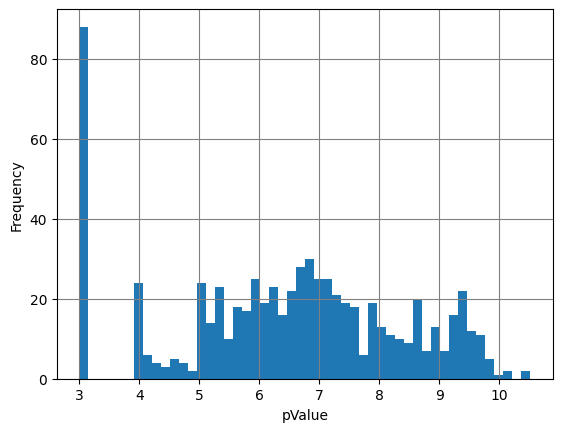

In [ ]:
df['pValue'].plot.hist(bins=50)
plt.grid(color='grey')
plt.xlabel('pValue')
plt.show()

Замечаем странный пик при pValue = 3. Может, это не взаимодействующие вещества?

HEAD


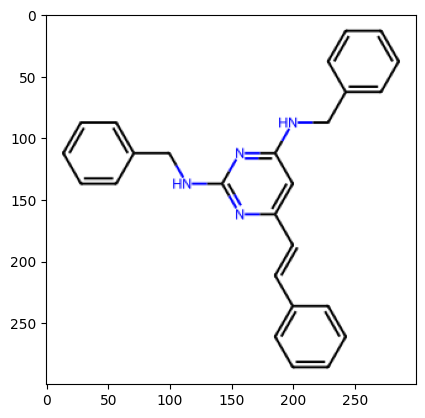

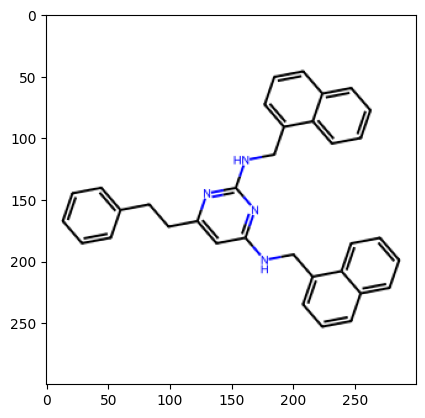

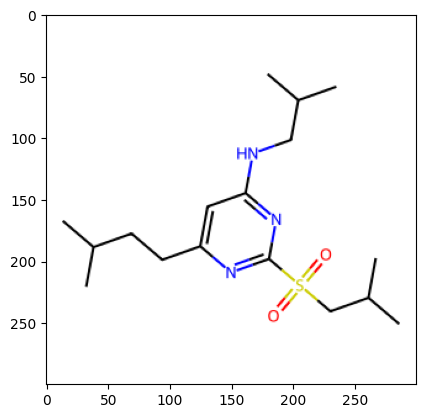

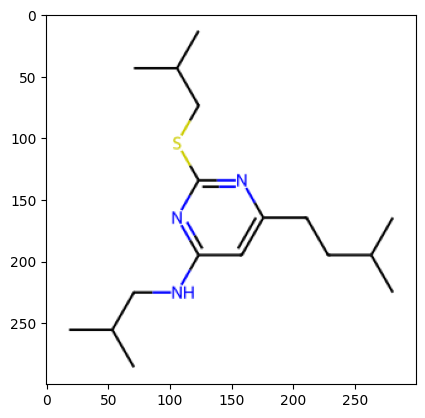

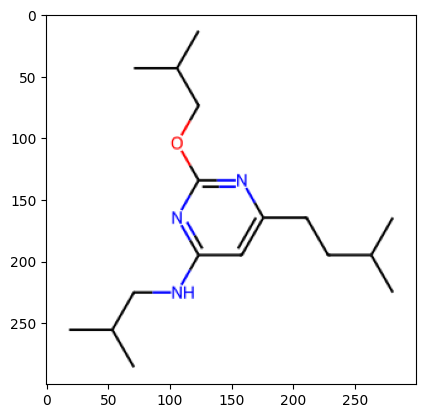

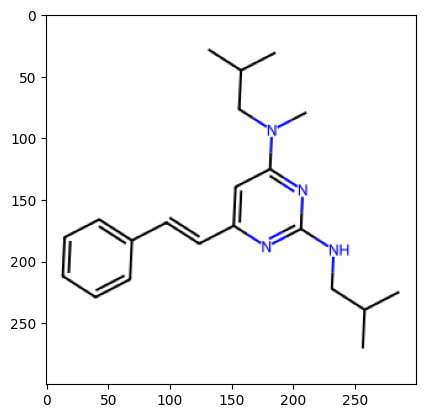

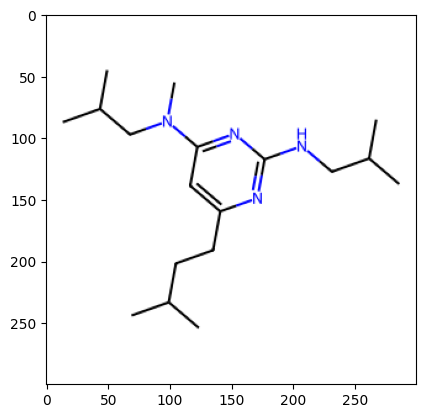

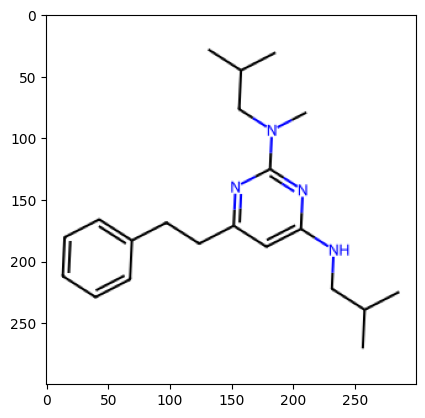

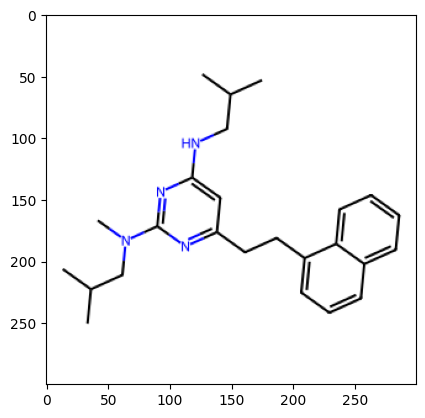

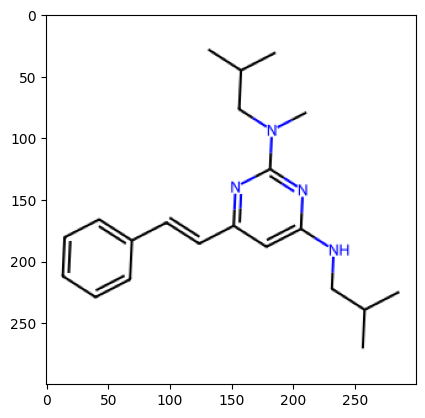

TAIL


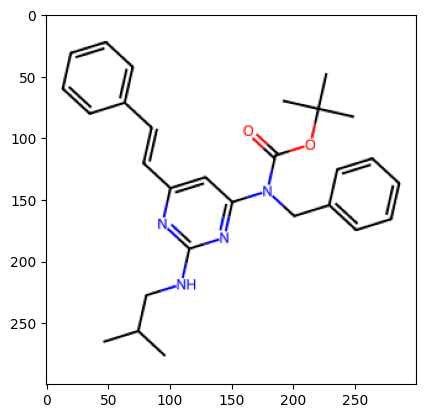

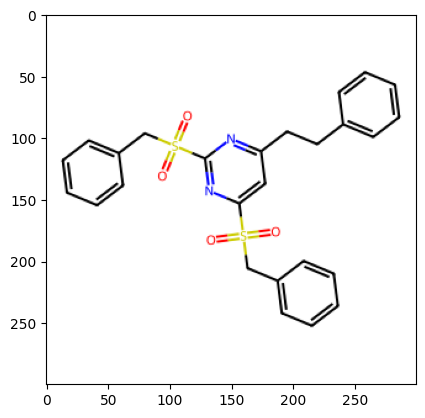

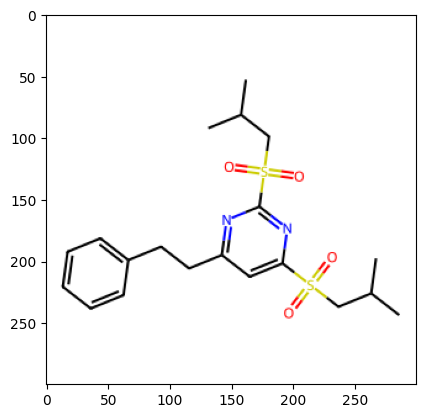

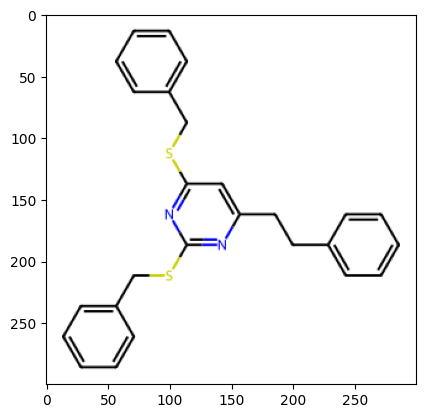

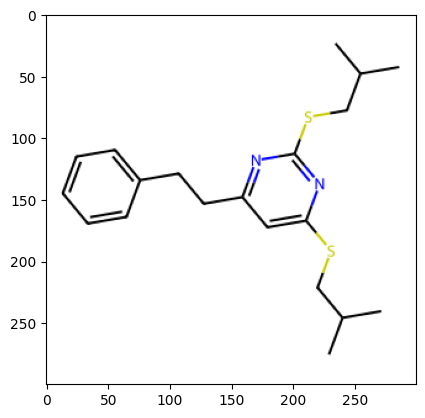

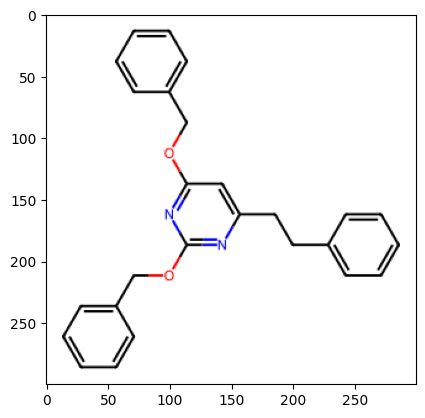

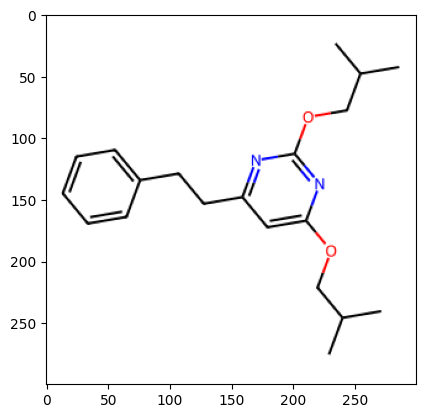

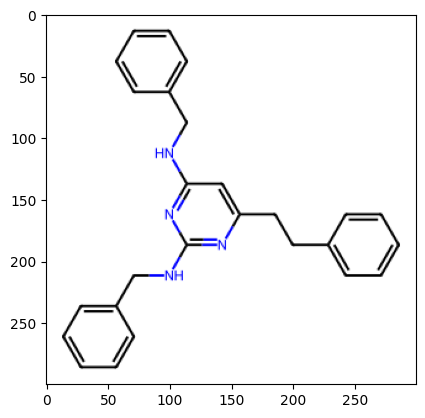

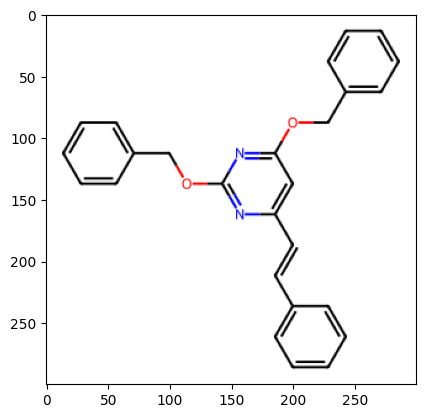

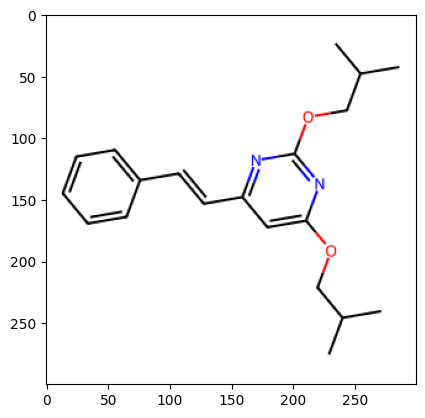

In [ ]:
print('HEAD')
for smile in df[df['pValue'] == 3].head(10)['MOL']:
    mol = Chem.MolFromSmiles(smile)
    img = Chem.Draw.MolToImage(mol)
    plt.imshow(img)
    plt.show()
print('TAIL')
for smile in df[df['pValue'] == 3].tail(10)['MOL']:
    mol = Chem.MolFromSmiles(smile)
    img = Chem.Draw.MolToImage(mol)
    plt.imshow(img)
    plt.show()

Похоже, что все они являются производными пиримидина.

## Преобразование данных к формату моделей

In [ ]:
X = df['fingerprint'].to_list()
# X = np.concatenate([(np.frombuffer(elem.ToBitString().encode(), 'u1') - ord('0')).reshape(-1, 1) for elem in X], axis=1).T
X = np.concatenate([elem.reshape(-1, 1) for elem in X], axis=1).T
y = df['pValue'].to_numpy()
# print(X.shape, y.shape)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [ ]:
X = np.concatenate([elem.reshape(-1, 1) for elem in X], axis=1).T
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(594, 2048)
(594,)
(105, 2048)
(105,)


## Модели

In [ ]:
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
models = [ \
    LinearRegression(),
    svm.SVR(kernel='rbf', C=1),
    KNeighborsRegressor(5),
    RFR(n_estimators=100),
    ]

In [ ]:
print('R^2 score:')
for model in models:
    scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    print(model)
    print('scores:', scores)
    print()

R^2 score:
LinearRegression()
scores: [-0.08860175  0.32757095 -0.68902718 -0.0692684  -1.49854313]

SVR(C=1)
scores: [ 0.30099077  0.56290715 -0.63739412  0.31795624 -0.02564506]

KNeighborsRegressor()
scores: [-0.33626636  0.58811862 -0.89485215  0.51029286 -0.43903749]

RandomForestRegressor()
scores: [ 0.36892664  0.55510179 -0.09409198  0.2683531  -0.50841047]



In [ ]:
print('neg MAPE score:')
for model in models:
    scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_percentage_error')
    print(model)
    print('scores:', scores)
    print()

neg MAPE score:
LinearRegression()
scores: [-0.17892215 -0.15623479 -0.58338518 -0.17182967 -0.17311161]

SVR(C=1)
scores: [-0.15022331 -0.13469791 -0.60742124 -0.15220774 -0.0917226 ]

KNeighborsRegressor()
scores: [-0.22074556 -0.12740176 -0.65035238 -0.13454318 -0.11419591]

RandomForestRegressor()
scores: [-0.11882391 -0.13701266 -0.47786563 -0.14929733 -0.13588672]

